In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import scipy as sp
import datetime as dt

from ei_net import * 
from ce_net import * 
from utilities import show_values

import cmocean as cmo

%matplotlib inline

In [2]:
##########################################
############ PLOTTING SETUP ##############
EI_cmap = "Greys"
where_to_save_pngs = "../figs/pngs/"
where_to_save_pdfs = "../figs/pdfs/"
save = True
plt.rc('axes', axisbelow=True)
plt.rc('axes', linewidth=2)
##########################################
##########################################

# Uncertainty and causal emergence in complex networks

# Chapter 04: Effective Information in Real Networks

$EI$ often grows with network size. To compare networks of different sizes, we examine their *effectiveness*, which is the $EI$ normalized by the size of the network to a value between $0.0$ and $1.0$:

$$ \text{effectiveness} = \frac{EI}{\log_2(N)} $$

As the noise and/or the degeneracy of a network increases toward their upper possible bounds, the effectiveness of that network will trend to $0.0$. Regardless of its size, a network wherein each node has a deterministic output to a unique target has an effectiveness of $1.0$. 

Here, we examine the effectiveness of 84 different networks corresponding to data from real systems. These networks were selected primarily from the [Konect Network Database](http://konect.cc/), which was used because its networks are publicly available, range in size from dozens to tens of thousands of nodes, often have a reasonable interpretation as a causal structure, and they are diverse, ranging from social networks, to power networks, to metabolic networks. We defined four categories of interest: biological, social, informational, and technological. We selected our networks by using all the available networks (under 40,000 nodes) in the domains corresponding to each category within the Konect database, and where it was appropriate, the [Network Repository](http://networkrepository.com/) as well. 

Lower effectiveness values correspond to structures that either have high degeneracy, low determinism, or a combination of both. In the networks we measured, biological networks on average have lower effectiveness values, whereas technological networks on average have the highest effectiveness. This finding aligns intuitively with what we know about the relationship between $EI$ and network structure, and it also supports long-standing hypotheses about the role of redundancy, degeneracy, and noise in biological systems. On the other hand, technological networks such as power grids, autonomous systems, or airline networks are associated with higher effectiveness values on average. One explanation for this difference is that efficiency in human-made technological networks tends to create sparser, non-degenerate networks with higher effectiveness on average.

Perhaps it might be surprising to find that evolved networks have such low effectiveness. But, as we will show, a low effectiveness can actually indicate that there are informative higher-scale (macroscale) dependencies in the system. That is, a low effectiveness can be reflective of the fact that biological systems often contain higher-scale causal structure, which we demonstrate in the following section.


________________________

## 4.1 Effectiveness of Real World Networks

In [3]:
import json
json_data = open('../data/real_network_ei.json',"r").read()
out_dict = json.loads(json_data)

In [4]:
list1 = out_dict['Eff']
list1 = list(enumerate(list1))
list2 = sorted(list1, key=lambda x:x[1])
ordering = list(list(zip(*list2))[0])
eff_vals = list(list(zip(*list2))[1])

In [5]:
newcos = ["#ed4f44","#fdcb12","#7f61c3","#00c6c5","#333333"]
cols = ['#88002c',"#ba4b57","#cc5134","#daaa32","#b8ab51","#698b4a","#69d07d","#50c9b5",
        "#64b6ff","#786bdb","#573689","#b55083","#c65abb","#bfbfbf","#666666","#333333"]

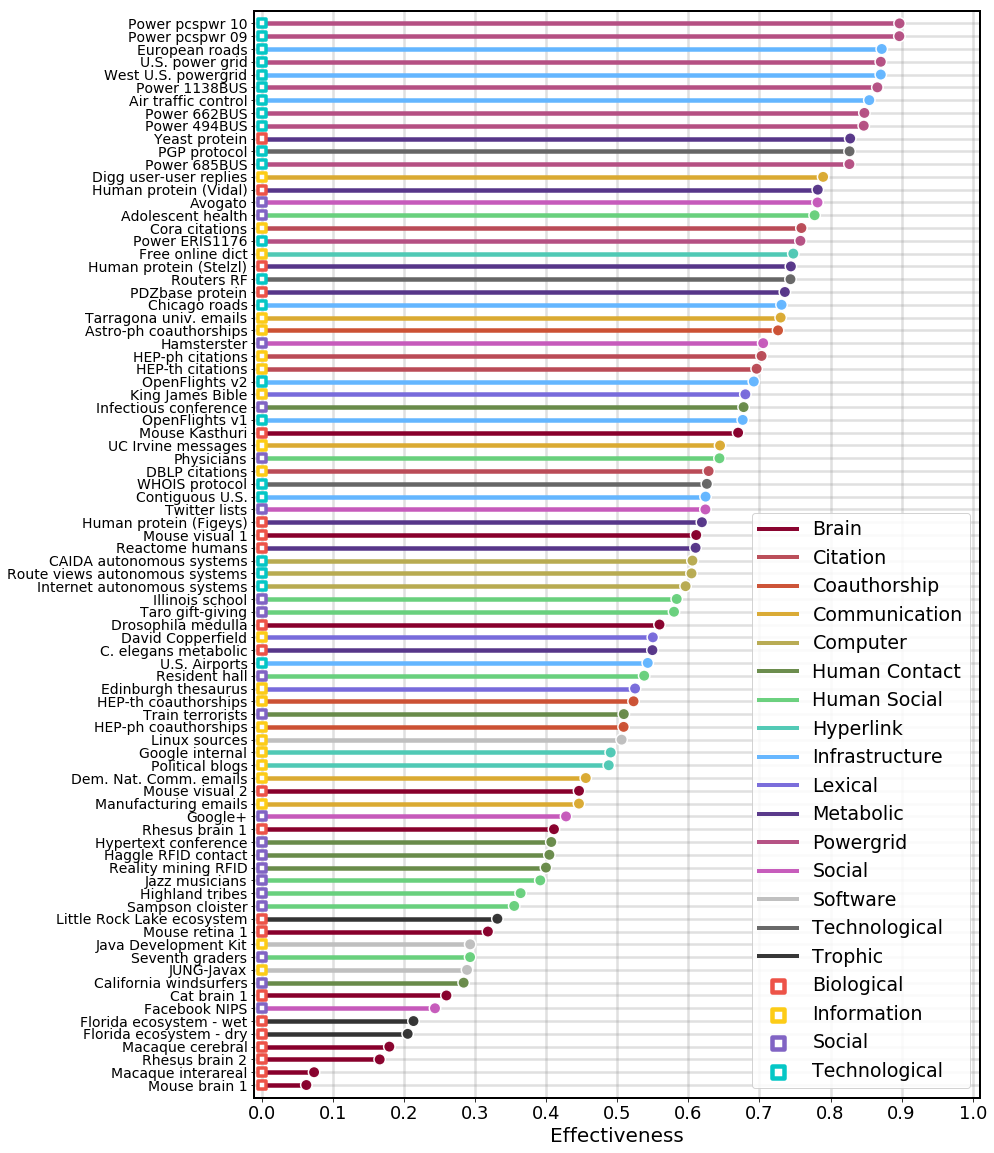

In [6]:
plt.figure(figsize=(13,20))

for idx,i in enumerate(ordering):
    co = out_dict['color'][i]
    ef = out_dict['Eff'][i]
    plt.hlines(idx,0,ef,color=co,linewidth=4.5)
    

plt.scatter(eff_vals, list(range(len(eff_vals))), edgecolors='w',linewidths=1.5,
            marker='o', s=130, alpha=0.98, facecolor=np.array(out_dict['color'])[ordering], zorder=20)
plt.scatter([0]*len(eff_vals), list(range(len(eff_vals))), 
            marker='s', s=65, alpha=0.98,edgecolors=np.array(out_dict['newco'])[ordering], 
            linewidths=3.5, facecolor='w', zorder=20)

for ii, lab in enumerate(['Biological','Information','Social','Technological']):
    plt.scatter([-1], [-1], 
            marker='s', s=125, alpha=0.98,edgecolors=newcos[ii], 
            linewidths=4.5, facecolor='w', label=lab)
    
for ii, lab in enumerate(sorted(np.unique(out_dict['Category']))):
    plt.plot([-10,-9], [-10,-9], marker='', alpha=0.98, linewidth=4.0,
             color=cols[ii], label=lab)

plt.legend(loc=4, fontsize=19, framealpha=0.85)
plt.yticks(list(range(len(eff_vals))), np.array(out_dict['Name'])[ordering], fontsize=14)
plt.xticks(np.linspace(0,1,11), ["%.1f"%i for i in np.linspace(0,1,11)], size=18)
plt.grid(alpha=0.3, color='#999999', linestyle='-', linewidth=2.5)
plt.xlabel('Effectiveness', size=20)
plt.xlim(-0.01,1.01)
plt.ylim(-1,len(eff_vals))

if save:
    plt.savefig(where_to_save_pngs+"Konect_SortedEffectiveness_withLabels.png", dpi=425, bbox_inches='tight')
    plt.savefig(where_to_save_pdfs+"Konect_SortedEffectiveness_withLabels.pdf", bbox_inches='tight')
plt.show()

## 4.2 Statistical Comparison of Effectiveness, by Domain

In [7]:
rn_bio = np.array([out_dict['Eff'][i] for i in range(len(out_dict['Eff'])) \
                   if out_dict['Category_EI'][i]=='Biological'])
rn_inf = np.array([out_dict['Eff'][i] for i in range(len(out_dict['Eff'])) \
                   if out_dict['Category_EI'][i]=='Information'])
rn_soc = np.array([out_dict['Eff'][i] for i in range(len(out_dict['Eff'])) \
                   if out_dict['Category_EI'][i]=='Social'])
rn_tec = np.array([out_dict['Eff'][i] for i in range(len(out_dict['Eff'])) \
                   if out_dict['Category_EI'][i]=='Technological'])

labs = {'biological':0,'social':2,"information":1,'technological':3}
a = labs['biological']
b = labs['social']

all_data = [rn_bio,rn_inf,rn_soc,rn_tec]

for lab1 in labs.keys():
    a = labs[lab1]
    for lab2 in labs.keys():
        b = labs[lab2]
        if a!=b:
            t,p = sp.stats.ttest_ind(all_data[a], all_data[b], equal_var=False)
            print("comparing",lab1,"       \t", "to \t ",lab2,"       \t t-statistic = %.7f, \t p < %.8f"%(t,p))

comparing biological        	 to 	  social        	 t-statistic = -1.2023872, 	 p < 0.23744675
comparing biological        	 to 	  information        	 t-statistic = -1.9001405, 	 p < 0.06608408
comparing biological        	 to 	  technological        	 t-statistic = -5.2740596, 	 p < 0.00001255
comparing social        	 to 	  biological        	 t-statistic = 1.2023872, 	 p < 0.23744675
comparing social        	 to 	  information        	 t-statistic = -0.9547772, 	 p < 0.34621068
comparing social        	 to 	  technological        	 t-statistic = -5.6426075, 	 p < 0.00000121
comparing information        	 to 	  biological        	 t-statistic = 1.9001405, 	 p < 0.06608408
comparing information        	 to 	  social        	 t-statistic = 0.9547772, 	 p < 0.34621068
comparing information        	 to 	  technological        	 t-statistic = -4.2445263, 	 p < 0.00021821
comparing technological        	 to 	  biological        	 t-statistic = 5.2740596, 	 p < 0.00001255
comparing technol

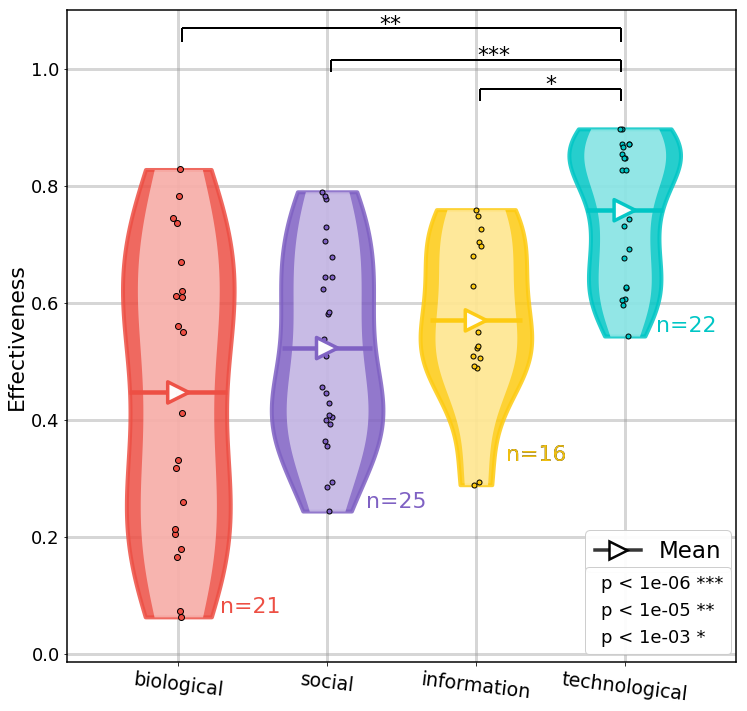

In [9]:
plt.rc('axes', linewidth=1.5)
mult = 0.8

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15*mult, 15*mult))

plt.plot([1]*len(all_data[0])+np.random.uniform(-0.035,0.035,len(all_data[0])),all_data[0],
         marker='o',linestyle='', markeredgecolor='k',
         markersize=6,color=newcos[0])
plt.plot([3]*len(all_data[1])+np.random.uniform(-0.035,0.035,len(all_data[1])),all_data[1],
         marker='o',linestyle='',markeredgecolor='k',
         markersize=5,color=newcos[1])
plt.plot([2]*len(all_data[2])+np.random.uniform(-0.035,0.035,len(all_data[2])),all_data[2],
         marker='o',linestyle='',markeredgecolor='k',
         markersize=5,color=newcos[2])
plt.plot([4]*len(all_data[3])+np.random.uniform(-0.035,0.035,len(all_data[3])),all_data[3],
         marker='o',linestyle='',markeredgecolor='k',
         markersize=5,color=newcos[3])            
    
parts = ax.violinplot(all_data, positions=[1,3,2,4], showmeans=False, showmedians=False, 
                      showextrema=False, widths=0.75)
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor(newcos[i])
    pc.set_facecolor(newcos[i])
    pc.set_alpha(0.85)
    pc.set_linewidth(4.0)
parts = ax.violinplot(all_data, positions=[1,3,2,4], showmeans=False, showmedians=False, 
                      showextrema=False, widths=0.55)
for i in range(len(parts['bodies'])):
    pc = parts['bodies'][i]
    pc.set_edgecolor(newcos[i])
    pc.set_facecolor('w')
    pc.set_alpha(0.5)
    pc.set_linewidth(0.0)

plt.hlines([np.mean(data) for data in all_data], [0.67, 2.6925, 1.695, 3.74], [1.33, 3.3075, 2.305, 4.26], 
           linestyles='-', colors=newcos, zorder=1, linewidth=4.5)

plt.plot(np.linspace(-10,-20,5), np.linspace(-10,-20,5), linestyle='-', marker='>', markersize=18, 
         markerfacecolor='w', color='#333333', linewidth=3.5, markeredgecolor='k', 
         markeredgewidth=2.5, label='Mean', alpha=0.98)

plt.scatter([1,3,2,4], [np.mean(data) for data in all_data], zorder=20,
           marker='>', s=450, facecolor='w', edgecolors=newcos, linewidths=3.5, alpha=0.98)

ax.set_ylabel('Effectiveness', fontsize=22)
ax.set_xticks([y+1 for y in range(len(all_data))])
ax.set_xticklabels(['biological', 'social', 'information', 'technological'],
                   fontsize=19, rotation=353)
ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels(["%.1f"%i for i in np.linspace(0,1,6)], fontsize=18)
ax.grid(True, linestyle='-', linewidth=3.0, color='#999999', alpha=0.4)

ax.text(1.28,0.07,"n=%i"%len(all_data[0]), fontsize=22, color=newcos[0])
ax.text(3.20,0.33,"n=%i"%len(all_data[1]), fontsize=22, color='k')
ax.text(3.20,0.33,"n=%i"%len(all_data[1]), fontsize=22, color=newcos[1],alpha=0.95)
ax.text(2.26,0.25,"n=%i"%len(all_data[2]), fontsize=22, color=newcos[2])
ax.text(4.21,0.55,"n=%i"%len(all_data[3]), fontsize=22, color=newcos[3])

ax.text(2.35,1.065,"**", fontsize=22)
ax.hlines(1.07, labs['biological']+1+0.025, labs['technological']+1-0.025, linewidth=2.0)
ax.vlines(labs['biological']+1+0.025, 1.045, 1.07, linewidth=2.0)
ax.vlines(labs['technological']+1-0.025, 1.045, 1.07, linewidth=2.0)

ax.text(3.01,1.012,"***", fontsize=22)
ax.hlines(1.015, labs['social']+0.025, labs['technological']+1-0.025, linewidth=2.0)
ax.vlines(labs['social']+0.025, 0.995, 1.015, linewidth=2.0)
ax.vlines(labs['technological']+1-0.025, 0.995, 1.015, linewidth=2.0)

ax.text(3.47,0.962,"*", fontsize=22)
ax.hlines(0.965, labs['information']+2+0.025, labs['technological']+1-0.025, linewidth=2.0)
ax.vlines(labs['information']+2+0.025, 0.945, 0.965, linewidth=2.0)
ax.vlines(labs['technological']+1-0.025, 0.945, 0.965, linewidth=2.0)

x1 = ax.plot([], [], marker='.', linestyle='', c='w')
x2 = ax.plot([], [], marker='.', linestyle='', c='w')
x3 = ax.plot([], [], marker='.', linestyle='', c='w')

legs=[x1,x2,x3]
leg1 = ax.legend(bbox_to_anchor=(1.009,0.22), fontsize=23, ncol=1, columnspacing=2, framealpha=0.95)
ax.legend([l[0] for l in legs], ["p < 1e-06 ***","p < 1e-05 **","p < 1e-03 *"], handletextpad=-1.50,
          bbox_to_anchor=(1.0055,0.16), fontsize=18, ncol=1, columnspacing=-3.75, framealpha=0.95)
ax.add_artist(leg1)
ax.set_ylim(-0.015, 1.1)
ax.set_xlim(0.25, 4.75)

if save:
    plt.savefig(where_to_save_pngs+"Konect_Effectiveness_Violinplots.png", dpi=425, bbox_inches='tight')
    plt.savefig(where_to_save_pdfs+"Konect_Effectiveness_Violinplots.pdf", bbox_inches='tight')
plt.show()

## End of Chapter 04. In [Chapter 05](https://nbviewer.jupyter.org/github/jkbren/einet/blob/master/code/Chapter%2005%20-%20Causal%20Emergence%20in%20Preferential%20Attachment%20and%20SBMs.ipynb) we'll start to look at *causal emergence* networks.
_______________